In [ ]:
# Import 3rd party libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

# Import local libraries
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import sklearn.metrics

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
plt.rcParams["figure.facecolor"] = "white"

Read the data file.

In [9]:
%cd -q "/home/w/wind/batukan/Documents/github/CIV1498-Project2"
data = pd.read_pickle('./dataframes/df_LA_parcels_LAcity_cleaned_REV2_MB.pkl', compression = "gzip")
data = data[data['TotalValue'] <= 2000000]
data = data[data['Neighborhood'].str.contains('Griffith Park') == False] # This is an outlier

In [10]:
data.shape

(417991, 20)

In [ ]:
crime_data = pd.read_csv('./datasets/neighbourhoods_crime_count_2010_to_2019.csv')
crime_data = crime_data[['name', 'crime_count']].rename(columns = {'name': 'Neighborhood'})
data = data.merge(crime_data, on = 'Neighborhood')
data

In [ ]:
neighborhood_cluster_data = pd.read_pickle('./dataframes/neighborhoods_cluster.pkl')
data = data.merge(neighborhood_cluster_data[['Neighborhood', 'cluster']], on = 'Neighborhood')
data

Check out the correlation between each of the current features of the data set.

In [14]:
correlation = data.corr()

<AxesSubplot:>

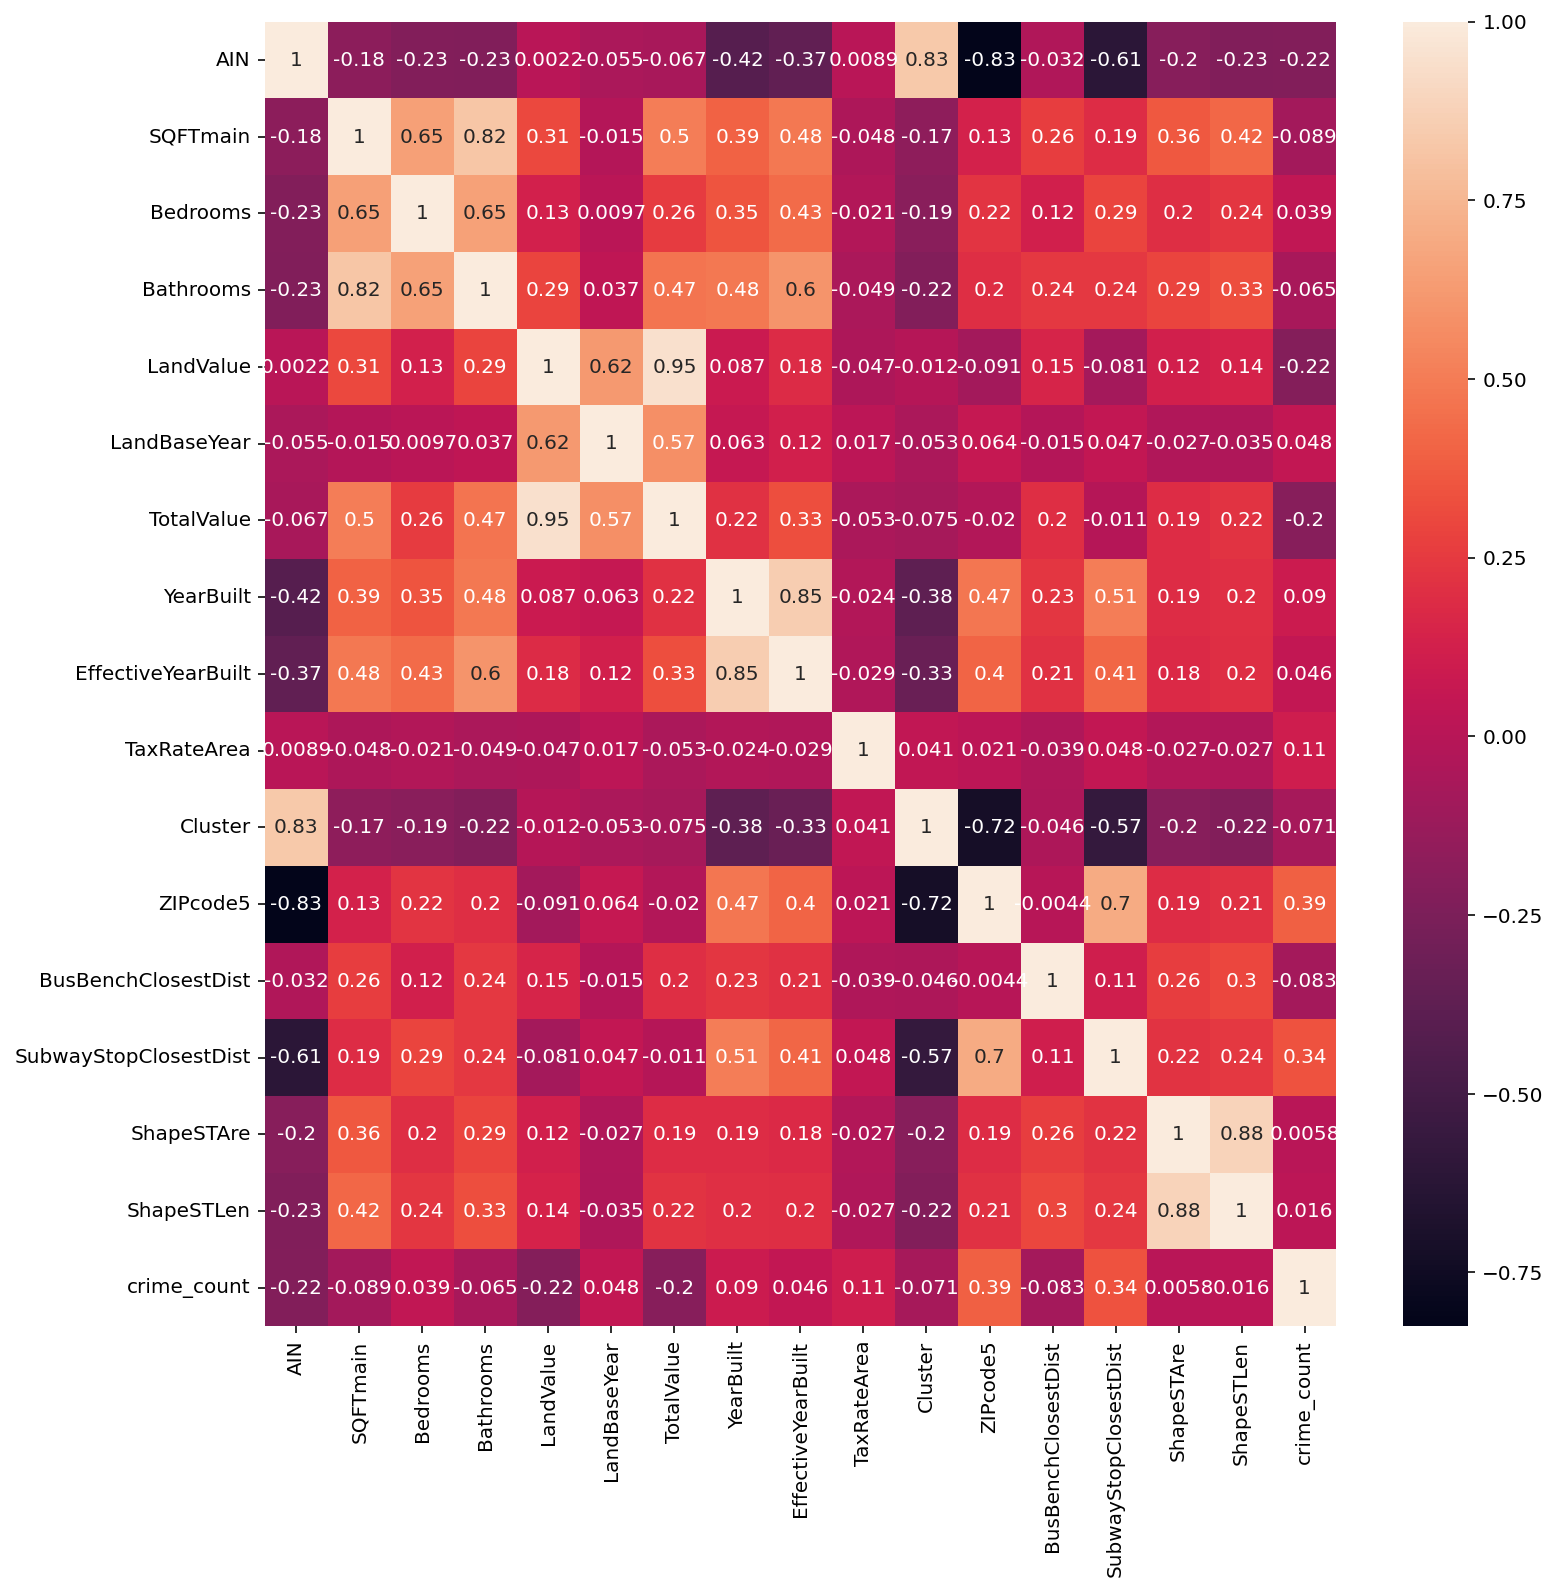

In [18]:
plt.figure(figsize = (12, 12))
sns.heatmap(correlation, annot=True)

Look at the info of each column in the data set.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417991 entries, 0 to 417990
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype   
---  ------                 --------------   -----   
 0   AIN                    417991 non-null  int64   
 1   SQFTmain               417991 non-null  float64 
 2   Bedrooms               417991 non-null  int64   
 3   Bathrooms              417991 non-null  int64   
 4   LandValue              417991 non-null  float64 
 5   LandBaseYear           417991 non-null  int64   
 6   TotalValue             417991 non-null  float64 
 7   YearBuilt              417991 non-null  int64   
 8   EffectiveYearBuilt     417991 non-null  int64   
 9   PropertyUseCode        417991 non-null  object  
 10  TaxRateArea            417991 non-null  int64   
 11  Cluster                417991 non-null  int64   
 12  ZIPcode5               417991 non-null  int64   
 13  ZIPcode4               416208 non-null  object  
 14  BusBenchClosestDist 

In [20]:
data.isnull().sum()

AIN                         0
SQFTmain                    0
Bedrooms                    0
Bathrooms                   0
LandValue                   0
LandBaseYear                0
TotalValue                  0
YearBuilt                   0
EffectiveYearBuilt          0
PropertyUseCode             0
TaxRateArea                 0
Cluster                     0
ZIPcode5                    0
ZIPcode4                 1783
BusBenchClosestDist         0
SubwayStopClosestDist       0
Neighborhood                0
ShapeSTAre                  0
ShapeSTLen                  0
geometry                    0
crime_count                 0
cluster                     0
dtype: int64

Split the data into training set, validation set, and test set.

In [37]:
df_dummy = data.copy()

for col in ["EffectiveYearBuilt", "YearBuilt", "TaxRateArea", "Cluster", "ZIPcode5", "ZIPcode4"]:
    df_dummy = df_dummy.loc[df_dummy[col].value_counts()[df_dummy[col].value_counts() != 1].index]

KeyError: "None of [Int64Index([16, 8852], dtype='int64')] are in the [index]"

In [39]:
df_dummy[col].value_counts()[df_dummy[col].value_counts() != 1]

16      14
8852     3
Name: TaxRateArea, dtype: int64

In [21]:
train, remainder = train_test_split(data, test_size=0.3, random_state=0, stratify=data[["EffectiveYearBuilt", "YearBuilt", "PropertyUseCode", "TaxRateArea", "Cluster", "ZIPcode5", "ZIPcode4", "Neighborhood"]])
val, test = train_test_split(remainder, test_size=0.5, random_state=0)

# Print results
print('Train {}%'.format(train.shape[0] / data.shape[0] * 100))
print('Val {}%'.format(val.shape[0] / data.shape[0] * 100))
print('Test {}%'.format(test.shape[0] / data.shape[0] * 100))

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

## Feature Engineering

Keep a list of thoughts of each feature and what to do with each feature <br>

Feature: <br>

AIN: No application. <br>

SQFTmain: Directly into Linear Regression Model. <br>

Bedrooms: Directly into Linear Regression Model. <br>

Bathrooms: Directly into Linear Regression Model. <br>

LandValue: Does not make sense to include in model, this would be part of the answer. Data leakage <br>

LandBaseYear: Defines how recently a piece of land was sold. Directly into model. <br>

TotalValue: This is the target. <br>

YearBuilt: Either this or the one below goes into the model. Effective year built also includes renovations and improvements but those could be subjective measures. <br>

EffectiveYearBuilt: Directly into Linear Regression Model. <br>

PropertyUseCode: Can one-hot-encode to measure changes in home value due to pool/no pool. <br>

TaxRateArea: Bad correlation with total value, so probably not useful in the ML model. <br>

Cluster: Bad correlation with total value, so probably not useful in the ML model. <br>

Zipcode5: No apparent correlation with TotalValue, might not be useful to predicting home prices. <br>

Zipcode4: Similar to zipcode5, but even worse because there are null values present. <br>

BusBenchClosestDist: Directly into Linear Regression Model. <br>

SubwayStopClosestDist: May not be the best indicator of home prices because subways can be quite loud to live near, so the convenience vs. noise may conflict with each other. Also must consider the quality of the subways in California, this would probably be a more useful feature in New York. <br>

Neighborhood: After graphing vs. TotalValue, it seems that all rich neighborhoods have cheap homes in them as well. This can be a good feature to detect strictly poor neighborhoods to add as a feature in the model, but might not be useful for rich neighborhoods due to high variance of home prices. <br>

ShapeSTAre: Directly into Linear Regression Model. <br>

ShapeSTLen: It seems redundant to include with ShapeSTAre. Try including it and see if the model improves. <br>

geometry: Maybe there could be a correlation to find what shapes of lots are more attractive. <br>

<br>
One hot encode the property use code to distinguish between homes with pools, without pools, etc.

In [ ]:
def ohe_pusecode(data):
    """
    One-hot-encodes Property Use Code.
    New columns are of the form PropertyUseCode_CODE
    """
    # List categories
    categories = ['0100', # No Pool
                  '0101', # Pool
                  '0103', # Pool and misc.
                  '0104', # Therapy Pool
                  ]

    category_type = pd.CategoricalDtype(categories=categories)
    data['PropertyUseCode'] = data['PropertyUseCode'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='PropertyUseCode',
                          columns=['PropertyUseCode'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_pusecode(train)

In [ ]:
training_data

In [ ]:
# Find relevant median values (by neighborhood) that might correlate with home prices
neighborhood_medians = (
    train[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'LandBaseYear', 'SQFTmain', 'TotalValue']]
    .groupby('Neighborhood').median()
)
neighborhood_medians

In [ ]:
neighborhood_medians.corr()

Since Real Estate prices are very dependent on its neighbors, these median values can be a useful representation of the overall condition of the neighborhood. Add median year built, effective year built, and sqft main to the data set. LandBaseYear seems to have low correlation so we will remove that, and total value would be data leakage.

In [ ]:
def median_neighborhood_merge(data):
    """
    Create a pipeline that:
    Finds median year built, effective year built, and sqftmain.
    Appends these values to the dataset.
    """
    # Find the median values
    neighborhood_medians = (
    data[['Neighborhood', 'YearBuilt', 'EffectiveYearBuilt', 'SQFTmain']]
    .groupby('Neighborhood').median()
    )
    
    # Append _median to all the column names in neighborhood_medians
    neighborhood_medians = neighborhood_medians.add_suffix('_median')
    
    # Merge with the original dataset
    data = pd.merge(left = data, right = neighborhood_medians, on = 'Neighborhood')
    
    return data

# Merge median values to the training set
training_data = median_neighborhood_merge(training_data)

In [ ]:
training_data

Take a look at the relationship between SQFTmain and Neighborhood. Wow, Californian homes are huge, every neighborhood has at least one home that is close to 5000 sqft.

In [ ]:
# Find a feature that can help distinguish between richer and "poorer" neighborhoods
fig, axs = plt.subplots(nrows=2, figsize=(12,8))

sns.boxplot(x='Neighborhood', y='SQFTmain', data=train.sort_values('Neighborhood'), ax=axs[0])
sns.boxplot(x='Neighborhood', y='TotalValue', data=train.sort_values('Neighborhood'), ax=axs[1])
plt.show

In [ ]:
train[['Neighborhood', 'SQFTmain']].groupby('Neighborhood').median().sort_values(by = 'SQFTmain', ascending = False).iloc[0:5]

It may be considered a data leakage to use TotalValue to find rich and poor neighborhoods, since TotalValue is the target. Use SQFTmain as a work around.

In [ ]:
def find_rich_neighborhoods(data, n = 2500, metric=np.median):
    """
    Find wealthy neighborhoods based on the median square footage of a residential property.
    n is the threshold median square footage that determines a rich neighborhood.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'SQFTmain']]                  # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
    )
    
    neighborhoods = neighborhoods[neighborhoods['SQFTmain'] > n].index.to_list()
    
    return neighborhoods

# Find rich neighborhoodsv
rich_neighborhoods = find_rich_neighborhoods(train)

# Print rich neighborhoods
print('The rich neighborhoods are: {}'.format(rich_neighborhoods))

In [ ]:
def find_poor_neighborhoods(data, n = 1150, metric=np.median):
    """
    Find poor neighborhoods based on the median square footage of a residential property.
    n is the threshold median square footage that determines a poor neighborhood.
    """
    
    # Write your code here.
    neighborhoods = (
        data[['Neighborhood', 'SQFTmain']]                  # Filter the columns of interest
        .groupby(data['Neighborhood'])                      # Group by neighborhoods
        .agg(metric)                                        # Apply the specified aggregation function, default is median
    )
    
    neighborhoods = neighborhoods[neighborhoods['SQFTmain'] < n].index.to_list()
    
    return neighborhoods

# Find poor neighborhoods
poor_neighborhoods = find_poor_neighborhoods(train)

# Print poor neighborhoods
print('The poor neighborhoods are: {}'.format(poor_neighborhoods))

In [ ]:
def add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood'
      rich_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
      poor_neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as poor
    Output:
      data frame identical to the input with the addition of two binary
      in_rich_neighborhood and in_poor_neighborhood columns
    """
    data_copy = data.copy()
    
    # Write your code here.
    data_copy['in_rich_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(rich_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    data_copy['in_poor_neighborhood'] = (
        data_copy['Neighborhood']           # Filter the series of interest
        .isin(poor_neighborhoods)                # Filter only the rich neighborhoods specified in the 'neighborhoods' list
        .astype('int32')                    # Convert the boolean values to integers
    )
    
    return data_copy

# Add 'in_rich_neighborhood' feature
training_data = add_in_neighborhoods(training_data, rich_neighborhoods, poor_neighborhoods)

# View DataFrame
training_data.head()

One hot encode the TaxRateArea

In [ ]:
taxrate_categories = data['TaxRateArea'].unique()

def ohe_taxratearea(data):
    """
    One-hot-encodes Tax Rate Area.
    New columns are of the form TaxRateArea_AREA
    """
    # List categories
    categories = taxrate_categories

    category_type = pd.CategoricalDtype(categories=categories)
    data['TaxRateArea'] = data['TaxRateArea'].astype(category_type)
    data = pd.get_dummies(data, 
                          prefix='TaxRateArea',
                          columns=['TaxRateArea'], 
                          drop_first=True) # Avoid redundant information
    
    return data

# Encode 'PropertyUseCode'
training_data = ohe_taxratearea(training_data)
training_data

In [ ]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

In [ ]:
training_data.info()

In [ ]:
def process_data(data):
    """Combine all pipelines to create processed data."""
    # One-hot-encode PropertyUseCode feature
    data = ohe_pusecode(data)
    
    # One-hot-encode TaxRateArea feature
    data = ohe_taxratearea(data)
    
    # Merge median neighborhood metrics
    data = median_neighborhood_merge(data)
    
    # Add in the rich and poor neighborhoods
    data = add_in_neighborhoods(data, rich_neighborhoods, poor_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandBaseYear',
                         'TotalValue',
                         'YearBuilt',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'TaxRateArea_8852',
                         'TaxRateArea_37',
                         'TaxRateArea_13',
                         'TaxRateArea_7',
                         'TaxRateArea_6659',
                         'TaxRateArea_67',
                         'TaxRateArea_292',
                         'TaxRateArea_51',
                         'TaxRateArea_13257',
                         'TaxRateArea_13261',
                         'TaxRateArea_13764',
                         'TaxRateArea_408',
                         'TaxRateArea_13766',
                         'TaxRateArea_5977',
                         'TaxRateArea_5976',
                         'TaxRateArea_13765',
                         'TaxRateArea_13767',
                         'TaxRateArea_5975',
                         'TaxRateArea_1725',
                         'TaxRateArea_464',
                         'TaxRateArea_50',
                         'TaxRateArea_65',
                         'TaxRateArea_2318',
                         'TaxRateArea_8856',
                         'TaxRateArea_8859',
                         'TaxRateArea_8849',
                         'TaxRateArea_8831',
                         'TaxRateArea_42',
                         'TaxRateArea_9938',
                         'TaxRateArea_1723',
                         'TaxRateArea_208',
                         'TaxRateArea_381',
                         'TaxRateArea_8860',
                         'TaxRateArea_660',
                         'TaxRateArea_212',
                         'TaxRateArea_304',
                         'TaxRateArea_6612',
                         'TaxRateArea_307',
                         'TaxRateArea_8842',
                         'TaxRateArea_4591',
                         'TaxRateArea_68',
                         'TaxRateArea_4592',
                         'TaxRateArea_414',
                         'TaxRateArea_210',
                         'TaxRateArea_3170',
                         'TaxRateArea_9951',
                         'TaxRateArea_401',
                         'TaxRateArea_398',
                         'TaxRateArea_2449',
                         'TaxRateArea_12',
                         'TaxRateArea_6660',
                         'TaxRateArea_204',
                         'TaxRateArea_56',
                         'TaxRateArea_8841',
                         'TaxRateArea_501',
                         'TaxRateArea_440',
                         'TaxRateArea_34',
                         'TaxRateArea_312',
                         'TaxRateArea_313',
                         'TaxRateArea_23',
                         'TaxRateArea_48',
                         'TaxRateArea_163',
                         'TaxRateArea_6657',
                         'TaxRateArea_36',
                         'TaxRateArea_29',
                         'TaxRateArea_30',
                         'TaxRateArea_35',
                         'TaxRateArea_12706',
                         'TaxRateArea_8830',
                         'TaxRateArea_6658',
                         'TaxRateArea_4',
                         'TaxRateArea_15117',
                         'TaxRateArea_12703',
                         'TaxRateArea_12704',
                         'TaxRateArea_27',
                         'TaxRateArea_9030',
                         'TaxRateArea_46',
                         'TaxRateArea_47',
                         'TaxRateArea_8827',
                         'TaxRateArea_201',
                         'TaxRateArea_200',
                         'TaxRateArea_324',
                         'TaxRateArea_8832',
                         'TaxRateArea_293',
                         'TaxRateArea_297',
                         'TaxRateArea_460',
                         'TaxRateArea_461',
                         'TaxRateArea_8834',
                         'TaxRateArea_6654',
                         'TaxRateArea_296',
                         'TaxRateArea_465',
                         'TaxRateArea_8835',
                         'TaxRateArea_463',
                         'TaxRateArea_284',
                         'TaxRateArea_509',
                         'TaxRateArea_6650',
                         'TaxRateArea_309',
                         'TaxRateArea_19',
                         'TaxRateArea_14',
                         'TaxRateArea_375',
                         'TaxRateArea_321',
                         'TaxRateArea_399',
                         'TaxRateArea_400',
                         'TaxRateArea_18',
                         'TaxRateArea_13245',
                         'TaxRateArea_372',
                         'TaxRateArea_21',
                         'TaxRateArea_482',
                         'TaxRateArea_497',
                         'TaxRateArea_20',
                         'TaxRateArea_308',
                         'TaxRateArea_470',
                         'TaxRateArea_484',
                         'TaxRateArea_13811'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

    Copy of all features considered for use:
    
    data = select_columns(data, 
                         'SQFTmain',
                         'Bedrooms',
                         'Bathrooms',
                         'LandBaseYear',
                         'TotalValue',
                         'YearBuilt',
                         'EffectiveYearBuilt',
                         'ShapeSTAre',
                         'ShapeSTLen',
                         'crime_count',
                         'PropertyUseCode_0101',
                         'PropertyUseCode_0103',
                         'PropertyUseCode_0104',
                         'YearBuilt_median',
                         'EffectiveYearBuilt_median',
                         'SQFTmain_median',
                         'in_rich_neighborhood',
                         'in_poor_neighborhood',
                         'TaxRateArea_8852',
                         'TaxRateArea_37',
                         'TaxRateArea_13',
                         'TaxRateArea_7',
                         'TaxRateArea_6659',
                         'TaxRateArea_67',
                         'TaxRateArea_292',
                         'TaxRateArea_51',
                         'TaxRateArea_13257',
                         'TaxRateArea_13261',
                         'TaxRateArea_13764',
                         'TaxRateArea_408',
                         'TaxRateArea_13766',
                         'TaxRateArea_5977',
                         'TaxRateArea_5976',
                         'TaxRateArea_13765',
                         'TaxRateArea_13767',
                         'TaxRateArea_5975',
                         'TaxRateArea_1725',
                         'TaxRateArea_464',
                         'TaxRateArea_50',
                         'TaxRateArea_65',
                         'TaxRateArea_2318',
                         'TaxRateArea_8856',
                         'TaxRateArea_8859',
                         'TaxRateArea_8849',
                         'TaxRateArea_8831',
                         'TaxRateArea_42',
                         'TaxRateArea_9938',
                         'TaxRateArea_1723',
                         'TaxRateArea_208',
                         'TaxRateArea_381',
                         'TaxRateArea_8860',
                         'TaxRateArea_660',
                         'TaxRateArea_212',
                         'TaxRateArea_304',
                         'TaxRateArea_6612',
                         'TaxRateArea_307',
                         'TaxRateArea_8842',
                         'TaxRateArea_4591',
                         'TaxRateArea_68',
                         'TaxRateArea_4592',
                         'TaxRateArea_414',
                         'TaxRateArea_210',
                         'TaxRateArea_3170',
                         'TaxRateArea_9951',
                         'TaxRateArea_401',
                         'TaxRateArea_398',
                         'TaxRateArea_2449',
                         'TaxRateArea_12',
                         'TaxRateArea_6660',
                         'TaxRateArea_204',
                         'TaxRateArea_56',
                         'TaxRateArea_8841',
                         'TaxRateArea_501',
                         'TaxRateArea_440',
                         'TaxRateArea_34',
                         'TaxRateArea_312',
                         'TaxRateArea_313',
                         'TaxRateArea_23',
                         'TaxRateArea_48',
                         'TaxRateArea_163',
                         'TaxRateArea_6657',
                         'TaxRateArea_36',
                         'TaxRateArea_29',
                         'TaxRateArea_30',
                         'TaxRateArea_35',
                         'TaxRateArea_12706',
                         'TaxRateArea_8830',
                         'TaxRateArea_6658',
                         'TaxRateArea_4',
                         'TaxRateArea_15117',
                         'TaxRateArea_12703',
                         'TaxRateArea_12704',
                         'TaxRateArea_27',
                         'TaxRateArea_9030',
                         'TaxRateArea_46',
                         'TaxRateArea_47',
                         'TaxRateArea_8827',
                         'TaxRateArea_201',
                         'TaxRateArea_200',
                         'TaxRateArea_324',
                         'TaxRateArea_8832',
                         'TaxRateArea_293',
                         'TaxRateArea_297',
                         'TaxRateArea_460',
                         'TaxRateArea_461',
                         'TaxRateArea_8834',
                         'TaxRateArea_6654',
                         'TaxRateArea_296',
                         'TaxRateArea_465',
                         'TaxRateArea_8835',
                         'TaxRateArea_463',
                         'TaxRateArea_284',
                         'TaxRateArea_509',
                         'TaxRateArea_6650',
                         'TaxRateArea_309',
                         'TaxRateArea_19',
                         'TaxRateArea_14',
                         'TaxRateArea_375',
                         'TaxRateArea_321',
                         'TaxRateArea_399',
                         'TaxRateArea_400',
                         'TaxRateArea_18',
                         'TaxRateArea_13245',
                         'TaxRateArea_372',
                         'TaxRateArea_21',
                         'TaxRateArea_482',
                         'TaxRateArea_497',
                         'TaxRateArea_20',
                         'TaxRateArea_308',
                         'TaxRateArea_470',
                         'TaxRateArea_484',
                         'TaxRateArea_13811'
                         )

In [ ]:
X_train, y_train = process_data(train)
    
X_train.head()

## Create Linear Regression Model

Create a cross-validation function returning the root mse from all splits

In [ ]:
def cross_validate_rmse(model, X, y):
    
    # Setup
    model = clone(model)
    five_fold = KFold(n_splits=5)   # Split the data into 5 parts
    rmse_values = []                # Initialize the list of rmse values, to be populated
    
    # Iterature through cv-folds
    for train_index, val_index in five_fold.split(X):
        
        # Write your code here.
        
        # Fit model
        model.fit(X.iloc[train_index], y.iloc[train_index])   # Take four parts as the training set, iterated through all possibilities
        y_predicted = model.predict(X.iloc[val_index])        # Take one part as the validation set
        
        # Append RMSE scores
        rmse_values.append(mean_squared_error(y.iloc[val_index], y_predicted, squared = False))   # Append to empty list per iteration to populate the rmse values list
        
    return rmse_values

In [ ]:
cv_scores = cross_validate_rmse(LinearRegression(), X_train, y_train)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

# Find the model percent error
print('Mean home price: ${}'.format(np.mean(data['TotalValue'])))

In [ ]:
X_val, y_val = process_data(val)
cv_scores = cross_validate_rmse(LinearRegression(), X_val, y_val)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

In [ ]:
X_test, y_test = process_data(test)
cv_scores = cross_validate_rmse(LinearRegression(), X_test, y_test)

# Print cv scores
print('Cross-validation RMSE scores: {}'.format(cv_scores))
print('Cross-validation RMSE scores mean: ${}'.format(np.mean(cv_scores)))
print('Cross-validation RMSE scores std: ${}'.format(np.std(cv_scores)))

## Try Gradient Descent

    columns = [
     'SQFTmain',
     'Bedrooms',
     'Bathrooms',
     'LandBaseYear',
     'YearBuilt',
     'EffectiveYearBuilt',
     'ShapeSTAre',
     'ShapeSTLen',
     'crime_count',
     'YearBuilt_median',
     'EffectiveYearBuilt_median',
     'SQFTmain_median'
    ]
Columns to standardize

In [ ]:
# Standardize features using standard scaling
def standardize_data(data, columns):
    """
    Standardize all the data to be number of std away from the mean.
    """
    
    for column in columns:
        data[column] = (data[column] - data[column].mean())/data[column].std()
    
    return data

### Try with Four Features

In [ ]:
def process_data_GD(data):
    """Combine all pipelines to create processed data."""
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'Bathrooms',
                         'LandBaseYear',
                         'TotalValue',
                         'EffectiveYearBuilt'
                         )
    
    # Standardize Data using Standard Scaling
    columns = [
     'SQFTmain',
     'Bathrooms',
     'LandBaseYear',
     'EffectiveYearBuilt'
    ]
    
    data = standardize_data(data, columns)
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

In [ ]:
X_train, y_train = process_data_GD(train)
    
X_train.head()

In [ ]:
def mse(theta0, theta1, theta2, theta3, theta4, X, y):
    y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1] + theta3*X.iloc[:, 2] + theta4*X.iloc[:, 3]
    return np.mean((y_hat - y) ** 2)

def grad_mse(theta0, theta1, theta2, theta3, theta4, X, y):
    y_hat = theta0 + theta1*X.iloc[:, 0] + theta2*X.iloc[:, 1] + theta3*X.iloc[:, 2] + theta4*X.iloc[:, 3]
    n = X.shape[0]
    grad_0 = (-2 / n) * sum(y - y_hat)
    grad_1 = (-2 / n) * sum(X.iloc[:, 0] * (y - y_hat)) 
    grad_2 = (-2 / n) * sum(X.iloc[:, 1] * (y - y_hat)) 
    grad_3 = (-2 / n) * sum(X.iloc[:, 2] * (y - y_hat)) 
    grad_4 = (-2 / n) * sum(X.iloc[:, 3] * (y - y_hat)) 
    return grad_0, grad_1, grad_2, grad_3, grad_4

In [ ]:
def minimize_GD(epochs, loss_fn, grad_loss_fn, X, y, alpha=0.2):
    """
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta once all thetas change less than 0.001 between iterations.
    """
    
    # Set starting epoch
    epochs = np.arange(epochs)
    epochs_conv = []
    
    # Set loss array
#     losses = []
    losses_conv = []
    
    # Set theta array
#     theta0s = []
#     theta1s = []
#     theta2s = []
#     theta3s = []
#     theta4s = []
    
    # Set starting theta
    theta0 = 10
    theta1 = 10
    theta2 = 10
    theta3 = 10
    theta4 = 10
    
    for epoch in epochs:

        # Update losses
#         losses.append(loss_fn(theta0, theta1, theta2, theta3, theta4, X, y))
        
        # Update thetas
#         theta0s.append(theta0)
#         theta1s.append(theta1)
#         theta1s.append(theta2)
#         theta1s.append(theta3)
#         theta1s.append(theta4)
        
        # Compute gradient
        grad_0, grad_1, grad_2, grad_3, grad_4 = grad_loss_fn(theta0, theta1, theta2, theta3, theta4, X, y)
        
        # Get new theta
        new_theta0 = theta0 - alpha * grad_0
        new_theta1 = theta1 - alpha * grad_1
        new_theta2 = theta2 - alpha * grad_2
        new_theta3 = theta3 - alpha * grad_3
        new_theta4 = theta4 - alpha * grad_4
        
        if (
            abs(new_theta0 - theta0) < 0.001 
            and abs(new_theta1 - theta1) < 0.001
            and abs(new_theta2 - theta2) < 0.001
            and abs(new_theta3 - theta3) < 0.001
            and abs(new_theta4 - theta4) < 0.001
        ):
            epochs_conv.append(epoch)
            losses_conv.append(loss_fn(theta0, theta1, theta2, theta3, theta4, X, y))
            break
          
        # Update theta
        theta0 = new_theta0
        theta1 = new_theta1
        theta2 = new_theta2
        theta3 = new_theta3
        theta4 = new_theta4
        
    return theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv

In [ ]:
theta0, theta1, theta2, theta3, theta4, epochs_conv, losses_conv = minimize_GD(
    epochs = 1000,
    loss_fn = mse,
    grad_loss_fn = grad_mse,
    X = X_train,
    y = y_train,
    alpha = 0.2
)

In [ ]:
print(theta0)
print(theta1)
print(theta2)
print(theta3)
print(theta4)
print(epochs_conv[0])
print(losses_conv[0]**0.5)

### Try with 1 Feature

In [ ]:
def process_data_GD_1D(data):
    """Combine all pipelines to create processed data."""
    # Transform Data, Select Features
    data = select_columns(data, 
                         'SQFTmain',
                         'TotalValue'
                         )
    
    # Standardize Data using Standard Scaling
    columns = ['SQFTmain']
    
    data = standardize_data(data, columns)
    
    # Return predictors and response variables separately
    X = data.drop(['TotalValue'], axis = 1)
    y = data.loc[:, 'TotalValue']
    
    return X, y

In [ ]:
X_train, y_train = process_data_GD_1D(train)
    
X_train.head()

In [ ]:
def mse_1D(theta0, theta1, X, y):
    y_hat = theta0 + theta1*X
    return np.mean((y_hat - y) ** 2)

def grad_mse_1D(theta0, theta1, X, y):
    y_hat = theta0 + theta1*X
    n = X.shape[0]
    grad_0 = (-2 / n) * sum(y - y_hat)
    grad_1 = (-2 / n) * sum(X * (y - y_hat)) 
    
    return grad_0, grad_1

In [ ]:
def minimize_GD_1D(epochs, loss_fn, grad_loss_fn, X, y, alpha=0.2):
    """
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta once all thetas change less than 0.001 between iterations.
    """
    
    # Set starting epoch
    epochs = np.arange(epochs)
    epochs_conv = []
    
    # Set loss array
#     losses = []
    losses_conv = []
    
    # Set theta array
#     theta0s = []
#     theta1s = []
    
    # Set starting theta
    theta0 = 10
    theta1 = 10
    
    for epoch in epochs:

        # Update losses
#         losses.append(loss_fn(theta0, theta1, X, y))
        
        # Update thetas
#         theta0s.append(theta0)
#         theta1s.append(theta1)
        
        # Compute gradient
        grad_0, grad_1 = grad_loss_fn(theta0, theta1, X, y)
        
        # Get new theta
        new_theta0 = theta0 - alpha * grad_0
        new_theta1 = theta1 - alpha * grad_1
        
        if (
            abs(new_theta0 - theta0) < 0.001 
            and abs(new_theta1 - theta1) < 0.001
        ):
            epochs_conv.append(epoch)
            losses_conv.append(loss_fn(theta0, theta1, X, y))
            break
          
        # Update theta
        theta0 = new_theta0
        theta1 = new_theta1
        
    return theta0, theta1, epochs_conv, losses_conv

In [ ]:
theta0, theta1, epochs_conv, losses_conv = minimize_GD_1D(
    epochs = 1000,
    loss_fn = mse_1D,
    grad_loss_fn = grad_mse_1D,
    X = X_train,
    y = y_train,
    alpha = 0.2
)

print(theta0)
print(theta1)
print(theta2)
print(theta3)
print(theta4)
print(epochs_conv[0])
print(losses_conv[0]**0.5)